In [4]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3
import json
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
def CollectTags(f):
    json_data = open("./SampleSet/"+f+"/"+f+".json")
    j = json.load(json_data)
    json_data.close()
    totalTags = ""
    for i in range(len(j)):
        if 'tags' in j[i].keys():
            try:
                string = " " + " ".join(str(b) for b in j[i]['tags'])
                totalTags += string
                #totalTags+=[str(b) for b in j[i]['tags']]
            except:
                pass
    return totalTags
        


In [25]:
titles = os.listdir("./SampleSet")
genres = ['HIIT circuit',"HIIT circuit", "Martial Arts", "Kickboxing", "Barre", "Yoga", "Barre", "HIIT circuit", "Yoga",
         "Cycling", "Yoga", "Yoga", "Barre", "Marital Arts", "Kickboxing", "Pilates", "Yoga", "Pilates", "Crossfit", "Crossfit",
         "Yoga", "Barre", "HIIT circuit", "Pilates", "HIIT circuit", "Cycling", "HIIT cicuit", "Kickboxing", "HIIT circuit",
         "Yoga", "Everything", "HIIT circuit", "Marital Arts", "Marital Arts", "HIIT ciruit", "Pilates", "Pilates", "Pilates", 
         "Yoga", "Yoga", "Marital Arts", "Yoga", "Yoga", "Everything", "Yoga", "Marital Arts", "Pilates", "Marital Arts",
         "Yoga", "HIIT circuit", "Cycling", "Yoga", "Yoga", "Yoga"]
hashtags = [CollectTags(f) for f in os.listdir("./SampleSet")]
ranks = [i for i in range(len(hashtags))]
#print (hashtags[0])

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, ngram_range=(1,1))
                                 #min_df=0.2, stop_words='english',
                                 #use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(hashtags)

print(tfidf_matrix.shape)

CPU times: user 439 ms, sys: 17.4 ms, total: 457 ms
Wall time: 468 ms
(54, 593)


In [17]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['2017', '4thofjuly', 'abs', 'acroyoga', 'active', 'activewear', 'adventure', 'aesthetics', 'amazing', 'america', 'anniversary', 'arms', 'art', 'asana', 'athleisure', 'athlete', 'awesome', 'backbend', 'backtoschool', 'badass', 'balance', 'bali', 'barre', 'bbg', 'beach', 'beachbody', 'beast', 'beastmode', 'beautiful', 'beauty', 'befit', 'behappy', 'behealthy', 'believe', 'believeinyourself', 'best', 'bestfriends', 'bestrong', 'bethechange', 'beyou', 'bikini', 'birthday', 'birthdaygirl', 'bjj', 'blessed', 'body', 'bodybuilding', 'boom', 'bootcamp', 'booty', 'bossbabe', 'boxing', 'breakfast', 'breathe', 'burn', 'burnbabyburn', 'burpees', 'cali', 'california', 'calisthenics', 'cantstopwontstop', 'cardio', 'celebrate', 'challenge', 'challengeyourself', 'change', 'charity', 'cheers', 'circuittraining', 'class', 'cleaneating', 'coach', 'coffee', 'commitment', 'community', 'competition', 'conditioning', 'confidence', 'consistency', 'core', 'corestrength', 'coreworkout', 'costamesa', 'crossfit'

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [19]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 377 ms, sys: 18.7 ms, total: 395 ms
Wall time: 516 ms


In [27]:
studios = { 'title': titles, 'rank': ranks, 'hashtags': hashtags, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(studios, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [28]:
frame['cluster'].value_counts()

1    16
2    13
4    11
3     9
0     5
Name: cluster, dtype: int64

grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

In [36]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind].split(' '), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d group:" % i, end='')
    for g in frame.ix[i]['genre'].values.tolist():
        print(' %s,' % g, end='')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: ['pilates'], ['pilatesreformer'], ['getfit'], ['exercise'], ['fitspo'], ['ocfitness'],

Cluster 0 titles: clubpilates, corereform, fitpilatesstudio, pilatesonpurpose, pilatespluscycle,

Cluster 0 group: Pilates, Pilates, Pilates, Pilates, Pilates,

Cluster 1 words: ['yogaeverydamnday'], ['namaste'], ['ocyoga'], ['yogalove'], ['yogi'], ['meditation'],

Cluster 1 titles: bakerranchyoga, bethechangeyoga, caffeyoga, corepoweryoga, ekamyoga, freedomride, mixxyoga, radianthotyoga, rayoga, spectrayoga, stellalunayoga, sunsparkyoga, triadyogaandpilates, vibeshotyoga, wildsideyoga, yogashaktistudio,

Cluster 1 group: Yoga, Yoga, Yoga, Yoga, Yoga, Cycling, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga,

Cluster 2 words: ['barre'], ['irvine'], ['tustin'], ['spin'], ['cardio'], ['fitfam'],

Cluster 2 titles: 12life, 3dfitnessgymoc, alkalignme, barmethod, bike2thebeattustin, bikramyogairvine, cardiobarre, enerjibarre, neaumixfit, pureempower, st

In [42]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'pilates, pilatesreformer, getfit, exercise, fitspo, ocfitness', 
                 1: 'yogaeverydamnday, namaste, ocyoga, yogalove, yogi, meditation', 
                 2: 'barre, irvine, tustin, spin, cardio, fitfam', 
                 3: 'mma, kickboxing, bjj, muaythai, boxing, ufc', 
                 4: 'fitfam, crossfit, fit, bootcamp, fitnessmotivation, gym'}

In [43]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [44]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


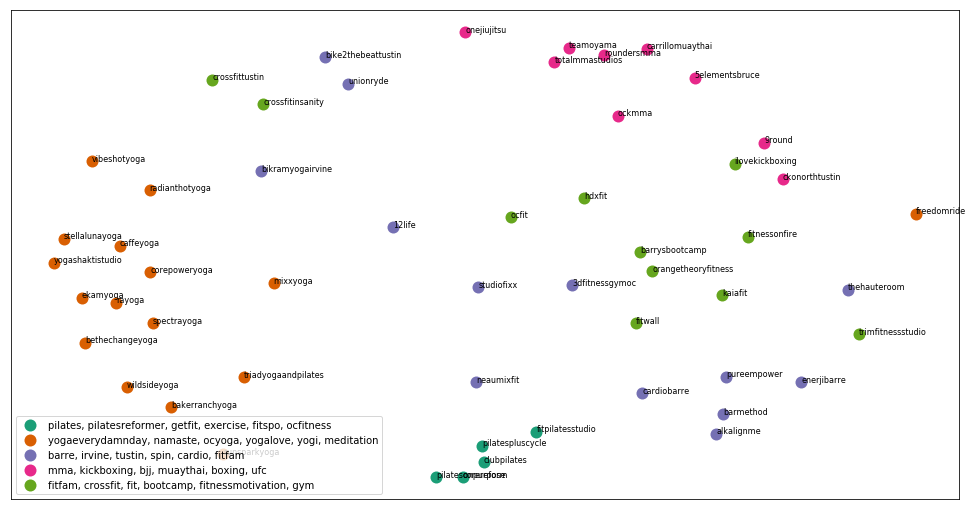

In [46]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)